Dataset bulundu: /kaggle/input/intel-image-classification/seg_train/seg_train
Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


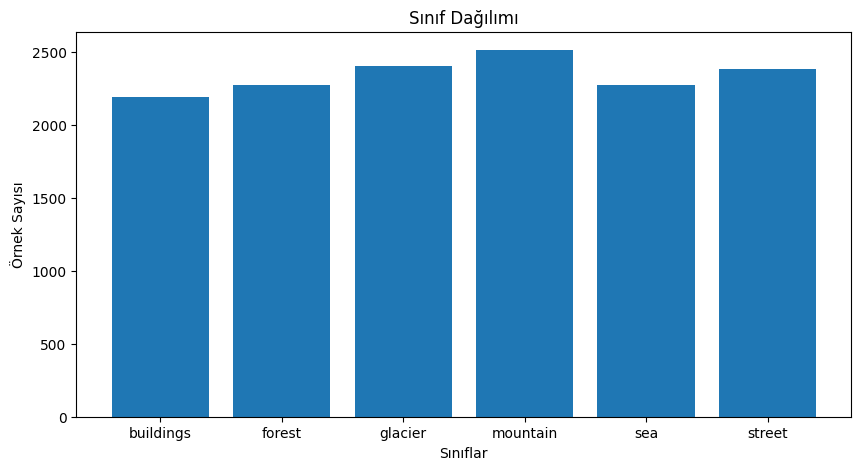

In [63]:
import os, pathlib, random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
import cv2
import keras_tuner as kt

possible_paths = [
    '/kaggle/input/intel-image-classification/seg_train/seg_train',
    '/kaggle/input/intel-image-classification/seg_train',
    '/kaggle/input/intel-image-classification',
    '/kaggle/input/seg_train/seg_train',
    '/kaggle/input/seg_train'
]

dataset_dir = None
for p in possible_paths:
    if os.path.exists(p):
        dataset_dir = p
        break

if dataset_dir is None:
    raise FileNotFoundError("Dataset bulunamadı.")
print("Dataset bulundu:", dataset_dir)

data_root = pathlib.Path(dataset_dir)
classes = sorted([p.name for p in data_root.iterdir() if p.is_dir()])
NUM_CLASSES = len(classes)
print("Sınıflar:", classes)

counts = {c: len(list((data_root/c).glob('*'))) for c in classes}
plt.figure(figsize=(10,5))
plt.bar(counts.keys(), counts.values())
plt.title("Sınıf Dağılımı")
plt.xlabel("Sınıflar")
plt.ylabel("Örnek Sayısı")
plt.show()


## Kütüphanelerin Yüklenmesi ve Dataset Kontrolü

Bu hücrede proje için gerekli olan temel kütüphaneler import edildi:

- **os, pathlib, random** → Dosya yolları, klasör yapısı ve rastgele seçimler için  
- **matplotlib, seaborn** → Görselleştirme ve istatistiksel grafikler için  
- **numpy** → Sayısal hesaplamalar için  
- **tensorflow / keras** → CNN modeli kurmak ve eğitmek için  
- **scikit-learn (train_test_split, confusion_matrix, classification_report)** → Eğitim/validasyon ayrımı ve değerlendirme metrikleri için  
- **MobileNetV2** → Transfer Learning (bonus) için  
- **cv2** → Görsel işleme işlemleri için  

Ayrıca, dataset’in Kaggle ortamında doğru şekilde yüklenip yüklenmediği kontrol edildi. Farklı olası yollar listelenerek dataset’in bulunması sağlandı. Eğer dataset bulunmazsa `FileNotFoundError` ile hata fırlatılıyor.

Son olarak:
- Veri setindeki **sınıf isimleri** listelendi.  
- Her sınıf için **örnek sayısı** hesaplanarak çubuk grafik (bar plot) ile görselleştirildi.  

In [64]:
all_paths, all_labels = [], []
for i, cls in enumerate(classes):
    files = list((data_root/cls).glob('*'))
    for f in files:
        if f.suffix.lower() in ('.jpg', '.jpeg', '.png'):
            all_paths.append(str(f))
            all_labels.append(i)

test_ratio = 0.10
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_paths, all_labels, test_size=test_ratio, stratify=all_labels, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.111111, stratify=train_labels, random_state=42
)
print("Split sizes (train, val, test):", len(train_paths), len(val_paths), len(test_paths))


Split sizes (train, val, test): 11226 1404 1404


### Dataset Hazırlığı

Bu hücrede, dataset içerisindeki tüm görüntülerin **dosya yolları** (`all_paths`) ve **etiketleri** (`all_labels`) çıkarılmıştır.  
Her sınıfın (ör. `buildings`, `forest`, `sea`) tüm dosya yolları listelenmiş ve sayısal etiketlere (`0,1,2,...`) dönüştürülmüştür.  

#### Veri Seti Bölme Stratejisi
- Veriler, **eğitim (train)**, **doğrulama (validation)** ve **test (test)** olmak üzere **3 parçaya** ayrılmıştır.
- **Oranlar:**  
  - %80 **Eğitim (Train)** → Modelin öğrenmesi için kullanılır.  
  - %10 **Doğrulama (Validation)** → Eğitim sırasında modelin overfit olup olmadığını görmek için kullanılır. Hiperparametre ayarlamaları (ör. öğrenme oranı, epoch sayısı) validation verisi üzerinden yapılır.  
  - %10 **Test** → Modelin eğitim süreci tamamlandıktan sonra nihai performansını ölçmek için kullanılır.  

#### Neden 80-10-10?
- Eğer yalnızca **train-test** bölmesi (ör. 80-20) yapsaydık, eğitim sürecinde modelin iyileştirilmesini kontrol edecek bağımsız bir **validation set** olmazdı.  
- Sadece `train-test` olduğunda:
  - **Validation set** için `test set`i kullanmak yanlış olur → çünkü test verisi en son model değerlendirmesi için saklanmalıdır.  
  - Dolayısıyla, modelin ayarlarını yaparken farkında olmadan test verisini “görmüş” oluruz → bu da **veri sızıntısı (data leakage)** problemine yol açar.  

80-10-10 ayırımı, eğitim süreci (train+val) ile nihai değerlendirme (test) süreçlerini ayırarak daha güvenilir bir model geliştirmemizi sağlar.


In [68]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Data Augmentation Layer
augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.12),
    layers.RandomContrast(0.1),
])

def load_and_preprocess(path, label, augment=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMG_SIZE)
    if augment:
        image = augmentation_layer(image, training=True)
    return image, tf.one_hot(label, NUM_CLASSES)

def make_dataset(paths, labels, batch=BATCH_SIZE, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), seed=42)
    ds = ds.map(lambda p,l: load_and_preprocess(p,l, augment=augment), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels, augment=True)
val_ds = make_dataset(val_paths, val_labels, shuffle=False, augment=False)
test_ds = make_dataset(test_paths, test_labels, shuffle=False, augment=False)


# Data Augmentation ve Dataset Fonksiyonları

Bu hücrede temel amaç **veri ön işleme ve veri artırma (data augmentation)** işlemlerini tanımlamak ve eğitim, doğrulama ve test veri setlerini oluşturmak.

---

## Parametreler
- `IMG_SIZE = (150, 150)` → Tüm resimler bu boyuta yeniden boyutlandırılır.
- `BATCH_SIZE = 64` → Eğitim sırasında batch boyutu.
- `AUTOTUNE` → TensorFlow’un veri pipeline’ını optimize etmek için kullanılır.

---

## Data Augmentation Layer
```python
augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.12),
    layers.RandomContrast(0.1),
])
```

- Eğitim sırasında veriye rastgele dönüşümler uygulanır.
- Amaç: Modelin overfitting’i azaltması ve genelleme kabiliyetini artırması.
- Sadece eğitim verisine uygulanır (augment=True).

### load_and_preprocess() Fonksiyonu

- Resmi dosyadan okur: tf.io.read_file(path).
- JPEG olarak decode eder ve float32 türüne çevirir.
- Boyutu IMG_SIZE olarak yeniden boyutlandırılır.
- augment=True ise augmentation layer’ı uygulanır.
- Label’ı one-hot encoding formatına çevirir.

### make_dataset() Fonksiyonu

- Dosya yolları ve label’ları alır, tf.data.Dataset objesi oluşturur.
- Shuffle ve map ile veriyi hazırlar, batch’ler ve prefetch uygular.
- Eğitim, doğrulama ve test setleri bu fonksiyonla oluşturulur:


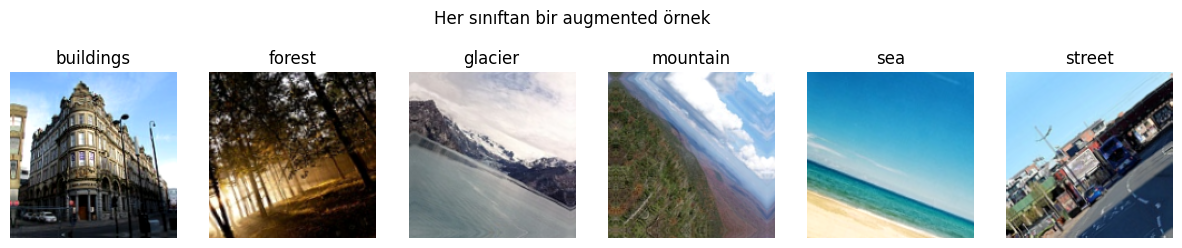

In [69]:
plt.figure(figsize=(15,3))
for idx, cls in enumerate(classes):
    cls_idx = classes.index(cls)
    cls_paths = [p for p, l in zip(train_paths, train_labels) if l == cls_idx]
    sample_path = random.choice(cls_paths)
    img, _ = load_and_preprocess(sample_path, cls_idx, augment=True)
    plt.subplot(1, NUM_CLASSES, idx+1)
    plt.imshow(img.numpy())
    plt.title(f"{cls}")
    plt.axis("off")
plt.suptitle("Her sınıftan bir augmented örnek")
plt.show()


# Augmented Örnek Görseller

Bu hücrede amaç, **data augmentation uygulanmış örnek görselleri görselleştirerek** eğitim verisindeki çeşitliliği kontrol etmektir.

---

## Adımlar

1. **Figure Oluşturma:**
```python
plt.figure(figsize=(15,3))
```
- Görsellerin yatayda 15, dikeyde 3 birim olacak şekilde boyutlandırılması.

2. **Sınıflardan Örnek Seçimi ve Görselleştirme:**
- Her sınıftan **rastgele bir örnek** seçilir.  
- `load_and_preprocess` fonksiyonu ile augmentation uygulanır (`augment=True`).  
- Her sınıf için subplot oluşturulur ve görsel ekranda gösterilir.  
- Başlık olarak sınıf adı eklenir; eksenler kapatılır (`axis("off")`).  

---

## Başlık ve Gösterim
- Tüm görsellerin üstüne genel başlık eklenir: `"Her sınıftan bir augmented örnek"`.  
- `plt.show()` ile figure ekranda görüntülenir.  

---

- Bu görselleştirme, modelin farklı varyasyonlarla nasıl beslenebileceğini anlamaya yardımcı olur.  
- Eğitim setindeki her sınıfın augmentation sonrası örnekleri gözlemlenebilir.


In [72]:
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers

def create_cnn_model_gradcam(input_shape=(150,150,3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)

    x = inputs

    x = layers.Conv2D(32, (3,3), padding="same", activation="relu", 
                      kernel_regularizer=regularizers.l2(0.001), name="conv1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), name="pool1")(x)

    x = layers.Conv2D(64, (3,3), padding="same", activation="relu", 
                      kernel_regularizer=regularizers.l2(0.001), name="conv2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), name="pool2")(x)

    x = layers.Conv2D(128, (3,3), padding="same", activation="relu", 
                      kernel_regularizer=regularizers.l2(0.001), name="conv3")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), name="pool3")(x)

    x = layers.Conv2D(256, (3,3), padding="same", activation="relu", 
                      kernel_regularizer=regularizers.l2(0.001), name="conv4")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), name="pool4")(x)

    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dense(256, activation="relu", 
                     kernel_regularizer=regularizers.l2(0.001), name="dense1")(x)
    x = layers.Dropout(0.3, name="dropout1")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="output")(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    optimizer = optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

cnn_model = create_cnn_model_gradcam()

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=1,
    callbacks=[early_stop]
)

last_conv_layer_cnn = "conv4"


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 231ms/step - accuracy: 0.5043 - loss: 1.8044 - val_accuracy: 0.1624 - val_loss: 2.8590
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 209ms/step - accuracy: 0.6772 - loss: 1.4143 - val_accuracy: 0.3212 - val_loss: 2.7803
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.7285 - loss: 1.2747 - val_accuracy: 0.5114 - val_loss: 1.7748
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 207ms/step - accuracy: 0.7465 - loss: 1.2260 - val_accuracy: 0.6111 - val_loss: 1.5182
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.7694 - loss: 1.1569 - val_accuracy: 0.7030 - val_loss: 1.2895
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.7792 - loss: 1.1300 - val_accuracy: 0.7635 - val_loss: 1.1242
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 36s 207ms/step - accuracy: 0.7916 - loss: 1.0858 - val_accuracy: 0.7486 - val_loss: 1.1542
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 37s 208ms/step - accuracy: 0.8025 - loss: 1

# CNN Modeli

Bu hücrede amaç, **augmentation uygulanmış eğitim verisi ile düzenlileştirme teknikleri (BatchNormalization, Dropout, L2 Regularization) kullanılan bir CNN modeli oluşturmak ve eğitmektir**. Ayrıca, Grad-CAM analizine uygun olacak şekilde son konvolüsyon katmanı seçilmiştir.

---

## Adımlar

### 1. Model Tanımı
- `create_cnn_model_gradcam` fonksiyonu ile CNN modeli oluşturulur.
- **Input:** `(150, 150, 3)` boyutunda renkli resimler.
- **Output:** `NUM_CLASSES` kadar sınıf için softmax aktivasyonu.

### 2. Convolutional Bloklar
- 4 adet Conv blok:
  1. Conv2D (32 filtre, **L2=0.001**) → BatchNormalization → MaxPooling2D
  2. Conv2D (64 filtre, **L2=0.001**) → BatchNormalization → MaxPooling2D
  3. Conv2D (128 filtre, **L2=0.001**) → BatchNormalization → MaxPooling2D
  4. Conv2D (256 filtre, **L2=0.001**) → BatchNormalization → MaxPooling2D
- Amaç: Görsel özellikleri hiyerarşik olarak öğrenmek ve L2 ile ağırlıkların aşırı büyümesini engelleyerek overfitting’i azaltmak.

### 3. GAP ve Dense Katmanları
- `GlobalAveragePooling2D`: Feature map'leri tek boyutlu vektöre çevirir.
- Dense(256, relu, **L2=0.001**) + Dropout(0.3): Ek regularization ile daha iyi genelleme.
- Output katmanı: Dense(num_classes, softmax) → sınıflandırma.

### 4. Compile
- Optimizer: `Adam` (lr=1e-4)
- Loss: `categorical_crossentropy`
- Metric: `accuracy`

### 5. Model Eğitimi
- Eğitim: `train_ds`  
- Doğrulama: `val_ds`  
- Epoch: 30  
- EarlyStopping: `monitor="val_loss"`, `patience=5`, `restore_best_weights=True`

### 6. Grad-CAM için Katman Seçimi
- `last_conv_layer_cnn = "conv4"`  
- Modelin Grad-CAM ile görselleştirme yapılacak son konvolüsyon katmanı.

---

## Eğitim Çıktıları
- Eğitim sürecinde `Epoch 3` sonrası **validation accuracy belirgin şekilde yükselmiştir**.  
- L2 regularization sayesinde, model **yüksek eğitim doğruluğuna ulaşırken validasyonda da dengeli bir performans göstermektedir**.  
- Bu, overfitting’in kontrol altına alındığını göstermektedir.

---

Model, **BatchNormalization + Dropout + L2 Regularization** ile düzenlileştirilmiş ve genelleme performansı iyileştirilmiştir. Grad-CAM analizi için uygun şekilde yapılandırılmıştır.

In [71]:
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # İlk etapta donduruyoruz

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x) 
x = layers.Dropout(0.5)(x)
output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

tl_model = models.Model(inputs=base_model.input, outputs=output)

optimizer = optimizers.Adam(learning_rate=1e-4)
tl_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6
)

tl_history = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)


/tmp/ipykernel_36/2797043023.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 48s 213ms/step - accuracy: 0.3792 - loss: 1.7482 - val_accuracy: 0.7956 - val_loss: 0.6269 - learning_rate: 1.0000e-04
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - accuracy: 0.7358 - loss: 0.7424 - val_accuracy: 0.8462 - val_loss: 0.4604 - learning_rate: 1.0000e-04
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 30s 171ms/step - accuracy: 0.7773 - loss: 0.6314 - val_accuracy: 0.8618 - val_loss: 0.4199 - learning_rate: 1.0000e-04
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - accuracy: 0.7997 - loss: 0.5783 - val_accuracy: 0.8682 - val_loss: 0.3879 - learning_rate: 1.0000e-04
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 30s 172ms/step - accuracy: 0.8158 - loss: 0.5322 - val_accuracy: 0.8668 - val_loss: 0.3795 - learning_rate: 1.0000e-04
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 30s 171ms/step - accuracy: 0.8177 - loss: 0.5233 - val_accuracy: 0.8704 - val_loss: 0.3642 - learning_rate: 1.0000e-04
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 31s 17

# Transfer Learning Modeli

Bu hücrede amaç, **önceden eğitilmiş MobileNetV2 modeli kullanarak transfer learning ile sınıflandırma yapmak**, eğitim süresini kısaltmak ve yüksek doğruluk elde etmektir.

---

## Adımlar

### 1. Base Model
- `MobileNetV2` önceden eğitilmiş ağı `imagenet` ağırlıklarıyla yüklenir.
- `include_top=False` → MobileNet’in orijinal sınıflandırma katmanı çıkarılır.
- `input_shape = IMG_SIZE + (3)` → Model giriş boyutu ayarlanır.
- `base_model.trainable = False` → Base model ağırlıkları **dondurulur**, sadece üst katmanlar eğitilir.

### 2. Yeni Üst Katmanlar
- `GlobalAveragePooling2D()`: Convolution katman çıktısını vektöre çevirir.
- `Dense(128, relu)`: Özellikleri işlemek için ek dense katmanı.
- `Dropout(0.5)`: Overfitting’i azaltmak için dropout.
- `Dense(NUM_CLASSES, softmax)`: Son katman, sınıflandırma için softmax aktivasyonu.

### 3. Model Compile
- **Optimizer**: `adam` (learning rate başlangıçta `1e-4`)
- **Loss**: `categorical_crossentropy`
- **Metric**: `accuracy`

### 4. Callback’ler
- `EarlyStopping`: Doğrulama kaybı gelişmezse erken durdurma, `restore_best_weights=True`
- `ReduceLROnPlateau`: Doğrulama kaybı iyileşmediğinde learning rate’i kademeli düşürme

### 5. Model Eğitimi
- Eğitim: `train_ds`
- Doğrulama: `val_ds`
- Epoch: 30
- `tl_history` ile eğitim geçmişi kaydedilir.
- İlk epoch’larda doğrulama doğruluğu hızlı yükselmiş (%80 → %88 civarı) ve learning rate gerektiğinde düşürülmüş.
- Model, base model dondurulduğu için eğitim hızlıdır ve sadece üst katmanlar güncellenir.
- Dropout ve Dense katmanları modelin genellemesini güçlendirir, overfitting azaltılır.

---

- `val_accuracy` ilk birkaç epoch’ta hızla yükselmiş ve stabilize olmuş.
- EarlyStopping ve ReduceLROnPlateau ile modelin öğrenme süreci optimize edilmiştir.
- Sonuç olarak transfer learning modeli hem hızlı hem de yüksek doğruluk elde eden bir modeldir.



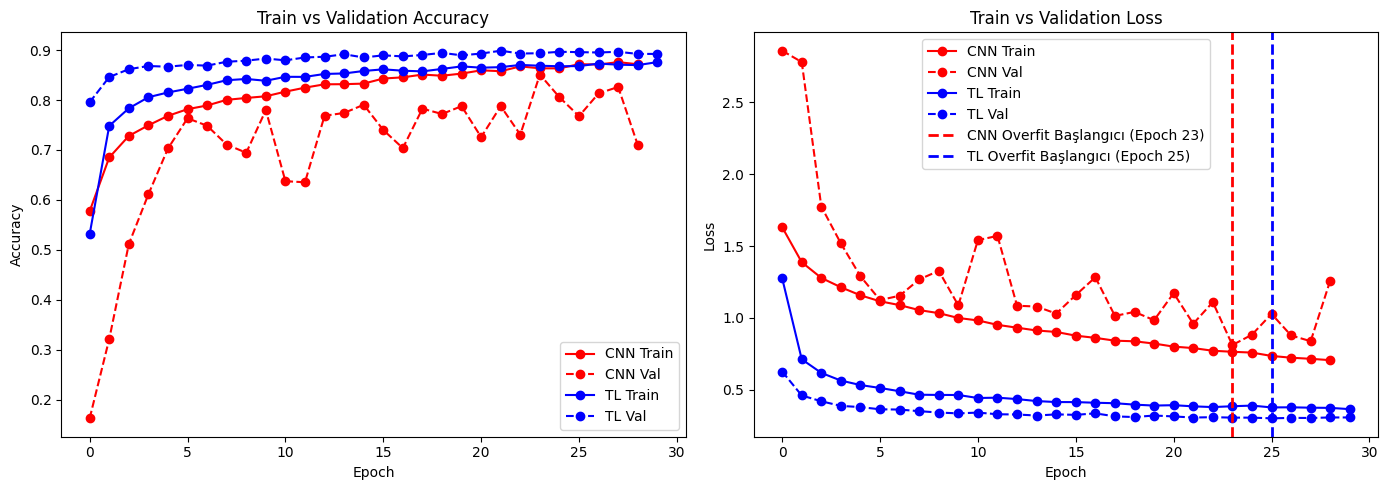

In [73]:
import numpy as np
import matplotlib.pyplot as plt

cnn_overfit_epoch = np.argmin(cnn_history.history['val_loss'])
tl_overfit_epoch = np.argmin(tl_history.history['val_loss'])

plt.figure(figsize=(14,5))

# Accuracy 
plt.subplot(1,2,1)
plt.plot(cnn_history.history['accuracy'], 'r-o', label='CNN Train')
plt.plot(cnn_history.history['val_accuracy'], 'r--o', label='CNN Val')
plt.plot(tl_history.history['accuracy'], 'b-o', label='TL Train')
plt.plot(tl_history.history['val_accuracy'], 'b--o', label='TL Val')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(cnn_history.history['loss'], 'r-o', label='CNN Train')
plt.plot(cnn_history.history['val_loss'], 'r--o', label='CNN Val')
plt.plot(tl_history.history['loss'], 'b-o', label='TL Train')
plt.plot(tl_history.history['val_loss'], 'b--o', label='TL Val')

# CNN Overfitting çizgisi
plt.axvline(x=cnn_overfit_epoch, color='red', linestyle='--', linewidth=2, 
            label=f'CNN Overfit Başlangıcı (Epoch {cnn_overfit_epoch})')

# TL Overfitting çizgisi (sadece val_loss artışı varsa)
plt.axvline(x=tl_overfit_epoch, color='blue', linestyle='--', linewidth=2, 
            label=f'TL Overfit Başlangıcı (Epoch {tl_overfit_epoch})')

plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Train & Validation Accuracy / Loss

Bu hücrede amaç, **CNN ve Transfer Learning modellerinin eğitim ve doğrulama performansını görselleştirmek** ve overfitting/underfitting durumlarını analiz etmektir.

---

### 1. Figure Oluşturma
- `plt.figure(figsize=(14,5))` → Grafik boyutu ayarlanır.

### 2. Accuracy Grafiği
- `plt.subplot(1,2,1)` → Sol tarafta subplot oluşturulur.
- CNN ve TL modellerinin:
  - *Eğitim doğruluğu* (`train`)
  - *Doğrulama doğruluğu* (`val`)
- Farklı renk ve çizgi stilleri ile çizilir:
  - CNN → kırmızı (`r`)
  - TL → mavi (`b`)
- Title, xlabel, ylabel ve legend eklenir.

### 3. Loss Grafiği
- `plt.subplot(1,2,2)` → Sağ tarafta subplot oluşturulur.
- CNN ve TL modellerinin:
  - *Eğitim kaybı* (`train loss`)
  - *Doğrulama kaybı* (`val loss`)
- Aynı şekilde renk ve çizgi stilleri kullanılır.

### 4. Overfitting Başlangıç Çizgileri
- CNN ve TL modelleri için validation loss'un minimum olduğu epoch tespit edilir:
  - `cnn_overfit_epoch = np.argmin(cnn_history.history['val_loss'])`
  - `tl_overfit_epoch = np.argmin(tl_history.history['val_loss'])`
- Bu epoch’lar sonrası validation loss artışı varsa **overfitting başladığı kabul edilir**.
- `plt.axvline()` ile kesikli çizgiler eklenir:
  - CNN → kırmızı (`color='red'`)
  - TL → mavi (`color='blue'`)
- Legend ile hangi çizginin hangi modelin overfitting başlangıcını gösterdiği belirtilir.

### 5. Layout ve Gösterim
- `plt.tight_layout()` → Grafikler arasındaki boşluk optimize edilir.
- `plt.show()` → Grafik ekranda gösterilir.

---

- Bu yöntem ile **hem eğitim hem doğrulama performansı görselleştirilir**, hem de **overfitting’in hangi epoch’ta başladığı kolayca tespit edilir**.  
- CNN ve TL modellerinin genelleme yetenekleri karşılaştırılabilir ve gerekirse erken durdurma veya regularization uygulanabilir.


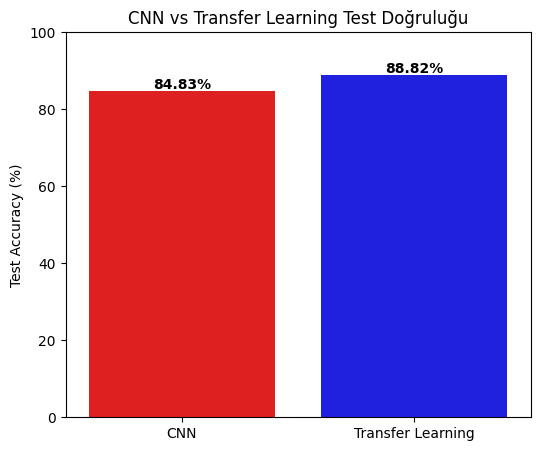

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_ds, verbose=0)
tl_test_loss, tl_test_acc = tl_model.evaluate(test_ds, verbose=0)

plt.figure(figsize=(6,5))
models_names = np.array(['CNN', 'Transfer Learning'])
accuracies = np.array([cnn_test_acc*100, tl_test_acc*100])

sns.barplot(x=models_names, y=accuracies, palette=['red','blue'])
plt.ylabel('Test Accuracy (%)')
plt.title('CNN vs Transfer Learning Test Doğruluğu')

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold')

plt.ylim(0, 100)
plt.show()


# Test Setinde Doğruluk Bar Grafiği

Bu hücrede amaç, **CNN ve Transfer Learning modellerinin test setindeki doğruluklarını karşılaştırmalı olarak görselleştirmektir**.

---

## Adımlar

### 1. Test Seti Değerlendirmesi
- `cnn_model.evaluate(test_ds, verbose=0)` → CNN modelinin test kaybı ve doğruluğu hesaplanır.
- `tl_model.evaluate(test_ds, verbose=0)` → Transfer Learning modelinin test kaybı ve doğruluğu hesaplanır.
- Sonuçlar sırasıyla:
  - `cnn_test_loss, cnn_test_acc`
  - `tl_test_loss, tl_test_acc`

### 2. Bar Grafiği Hazırlama
- `plt.figure(figsize=(6,5))` → Grafik boyutu belirlenir.
- Model isimleri: `['CNN', 'Transfer Learning']`
- Doğruluklar (%): `[cnn_test_acc*100, tl_test_acc*100]`
- `sns.barplot` ile çubuk grafiği çizilir:
  - CNN → kırmızı
  - TL → mavi
- Y-ekseni: Test Accuracy (%)  
- Başlık: `"CNN vs Transfer Learning Test Doğruluğu"`

### 3. Değer Etiketleri
- Her çubuğun üzerine doğruluk yüzdesi yazılır:
  ```python
  for i, v in enumerate(accuracies):
      plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontweight='bold')
  ```
- plt.ylim(0, 100) → Y-ekseni 0-100 aralığına sabitlenir.

### 4. Gösterim

- `plt.show()` → Grafik ekranda gösterilir.


--- CNN Confusion Matrix ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


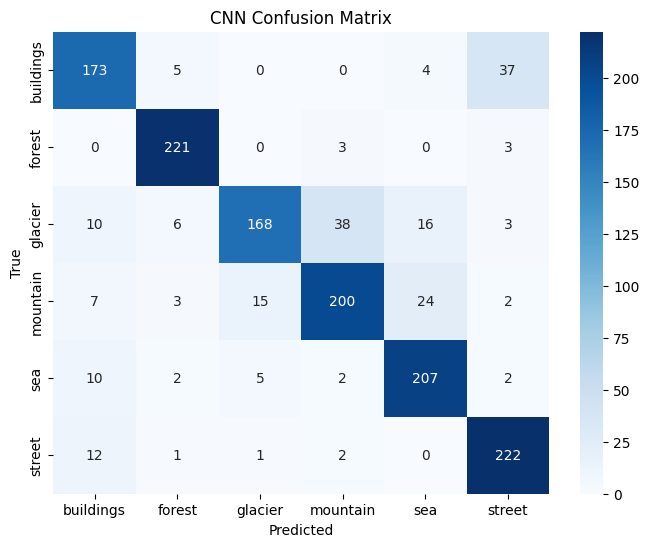

              precision    recall  f1-score   support

   buildings       0.82      0.79      0.80       219
      forest       0.93      0.97      0.95       227
     glacier       0.89      0.70      0.78       241
    mountain       0.82      0.80      0.81       251
         sea       0.82      0.91      0.86       228
      street       0.83      0.93      0.88       238

    accuracy                           0.85      1404
   macro avg       0.85      0.85      0.85      1404
weighted avg       0.85      0.85      0.85      1404


--- TL Confusion Matrix ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step


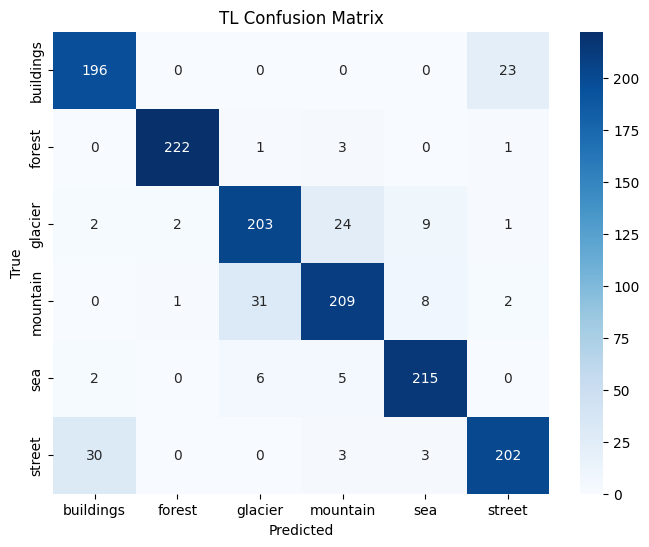

              precision    recall  f1-score   support

   buildings       0.85      0.89      0.87       219
      forest       0.99      0.98      0.98       227
     glacier       0.84      0.84      0.84       241
    mountain       0.86      0.83      0.84       251
         sea       0.91      0.94      0.93       228
      street       0.88      0.85      0.87       238

    accuracy                           0.89      1404
   macro avg       0.89      0.89      0.89      1404
weighted avg       0.89      0.89      0.89      1404



In [76]:
for model_name, model_obj in zip(['CNN','TL'], [cnn_model, tl_model]):
    print(f"\n--- {model_name} Confusion Matrix ---")
    y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_probs = model_obj.predict(test_ds)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    print(classification_report(y_true_labels, y_pred_labels, target_names=classes))


# Confusion Matrix

Bu hücrede amaç, **CNN ve Transfer Learning modellerinin test setindeki sınıf bazlı performansını görselleştirmek** ve hangi sınıflarda hatalar yaptığını analiz etmektir.

---

## Adımlar

### 1. Döngü ile Modelleri Değerlendirme
- `zip(['CNN','TL'], [cnn_model, tl_model])` → Her iki model için işlemler tekrarlanır.
- `y_true` → Test setindeki gerçek label’lar (`one-hot`) birleştirilir.
- `y_true_labels` → Gerçek label’lar `argmax` ile integer formata çevrilir.
- `y_pred_probs` → Modelin test seti üzerindeki tahmin olasılıkları.
- `y_pred_labels` → Tahmin edilen sınıflar `argmax` ile seçilir.

### 2. Confusion Matrix Hesaplama
- `cm = confusion_matrix(y_true_labels, y_pred_labels)` → Sınıf bazlı doğruluk matrisini oluşturur.
- `sns.heatmap` ile görselleştirilir:
  - Annotasyon: `annot=True, fmt='d'` → Sayıları hücrelerde gösterir.
  - X ve Y etiketleri: Sınıf isimleri (`classes`)
  - Renk paleti: `Blues`

### 3. Görselleştirme
- `plt.figure(figsize=(8,6))` → Grafik boyutu ayarlanır.
- X-ekseni: Predicted (Tahmin edilen)
- Y-ekseni: True (Gerçek)
- Başlık: `"{model_name} Confusion Matrix"`
- `plt.show()` → Grafik ekranda gösterilir.

### 4. Sınıf Bazlı Performans Raporu
- `classification_report(y_true_labels, y_pred_labels, target_names=classes)`  
  - Her sınıf için precision, recall, f1-score ve support değerlerini verir.


In [77]:
def get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name, class_idx):
    img = tf.keras.utils.load_img(img_path, target_size=(150,150))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    heatmap = get_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=class_idx)
    heatmap = cv2.resize(heatmap, (150,150))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img_np = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)


# Grad-CAM Fonksiyonları

Bu hücrede amaç, **Grad-CAM (Gradient-weighted Class Activation Mapping) kullanarak modelin hangi bölgeleri dikkate aldığını görselleştirmek** ve karar mekanizmasını analiz etmektir.

---

## Fonksiyonlar

### 1. `get_gradcam_heatmap()`
- Girdi:
  - `img_array`: Modelin tahmin yapacağı resim.
  - `model`: Kullanılacak CNN veya Transfer Learning modeli.
  - `last_conv_layer_name`: Grad-CAM için son konvolüsyon katmanı.
  - `pred_index`: Hangi sınıf için heatmap üretileceği (varsayılan olarak modelin tahmini sınıfı).
- İşlem:
  1. `grad_model`: Son konvolüsyon katmanı ve model çıktısını alacak şekilde alt model oluşturulur.
  2. `GradientTape` ile sınıf skoruna göre konvolüsyon çıktıları için gradyan hesaplanır.
  3. Gradyanlar spatial olarak ortalanır (`pooled_grads`).
  4. Konvolüsyon çıktıları ile gradyanlar çarpılır ve ortalanarak heatmap elde edilir.
  5. Heatmap normalize edilir ve numpy array olarak döndürülür.
- Amaç: Modelin **hangi bölgelere dikkat ettiğini** sayısal olarak çıkarmak.

### 2. `display_gradcam()`
- Girdi:
  - `img_path`: Görselleştirilecek resim yolu.
  - `model`: Kullanılacak model.
  - `last_conv_layer_name`: Grad-CAM için son konvolüsyon katmanı.
  - `class_idx`: Heatmap’in hangi sınıfa göre üretileceği.
- İşlem:
  1. Resim yüklenir ve 0-1 aralığında normalize edilir.
  2. `get_gradcam_heatmap` ile heatmap elde edilir.
  3. Heatmap, resim boyutuna göre yeniden boyutlandırılır ve renk haritası uygulanır.
  4. Heatmap, orijinal resim üzerine ağırlıklı olarak bindirilir (`superimposed_img`).
  5. RGB formatında döndürülür.
- Amaç: Heatmap ile **modelin karar verdiği görsel bölgeleri görselleştirmek**.

---
- Görselleştirme sayesinde modelin hangi özelliklere odaklandığı anlaşılabilir ve interpretability artırılır.


Son konvolüsyon katmanı bulundu: Conv_1_bn


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2816']
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2658']
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


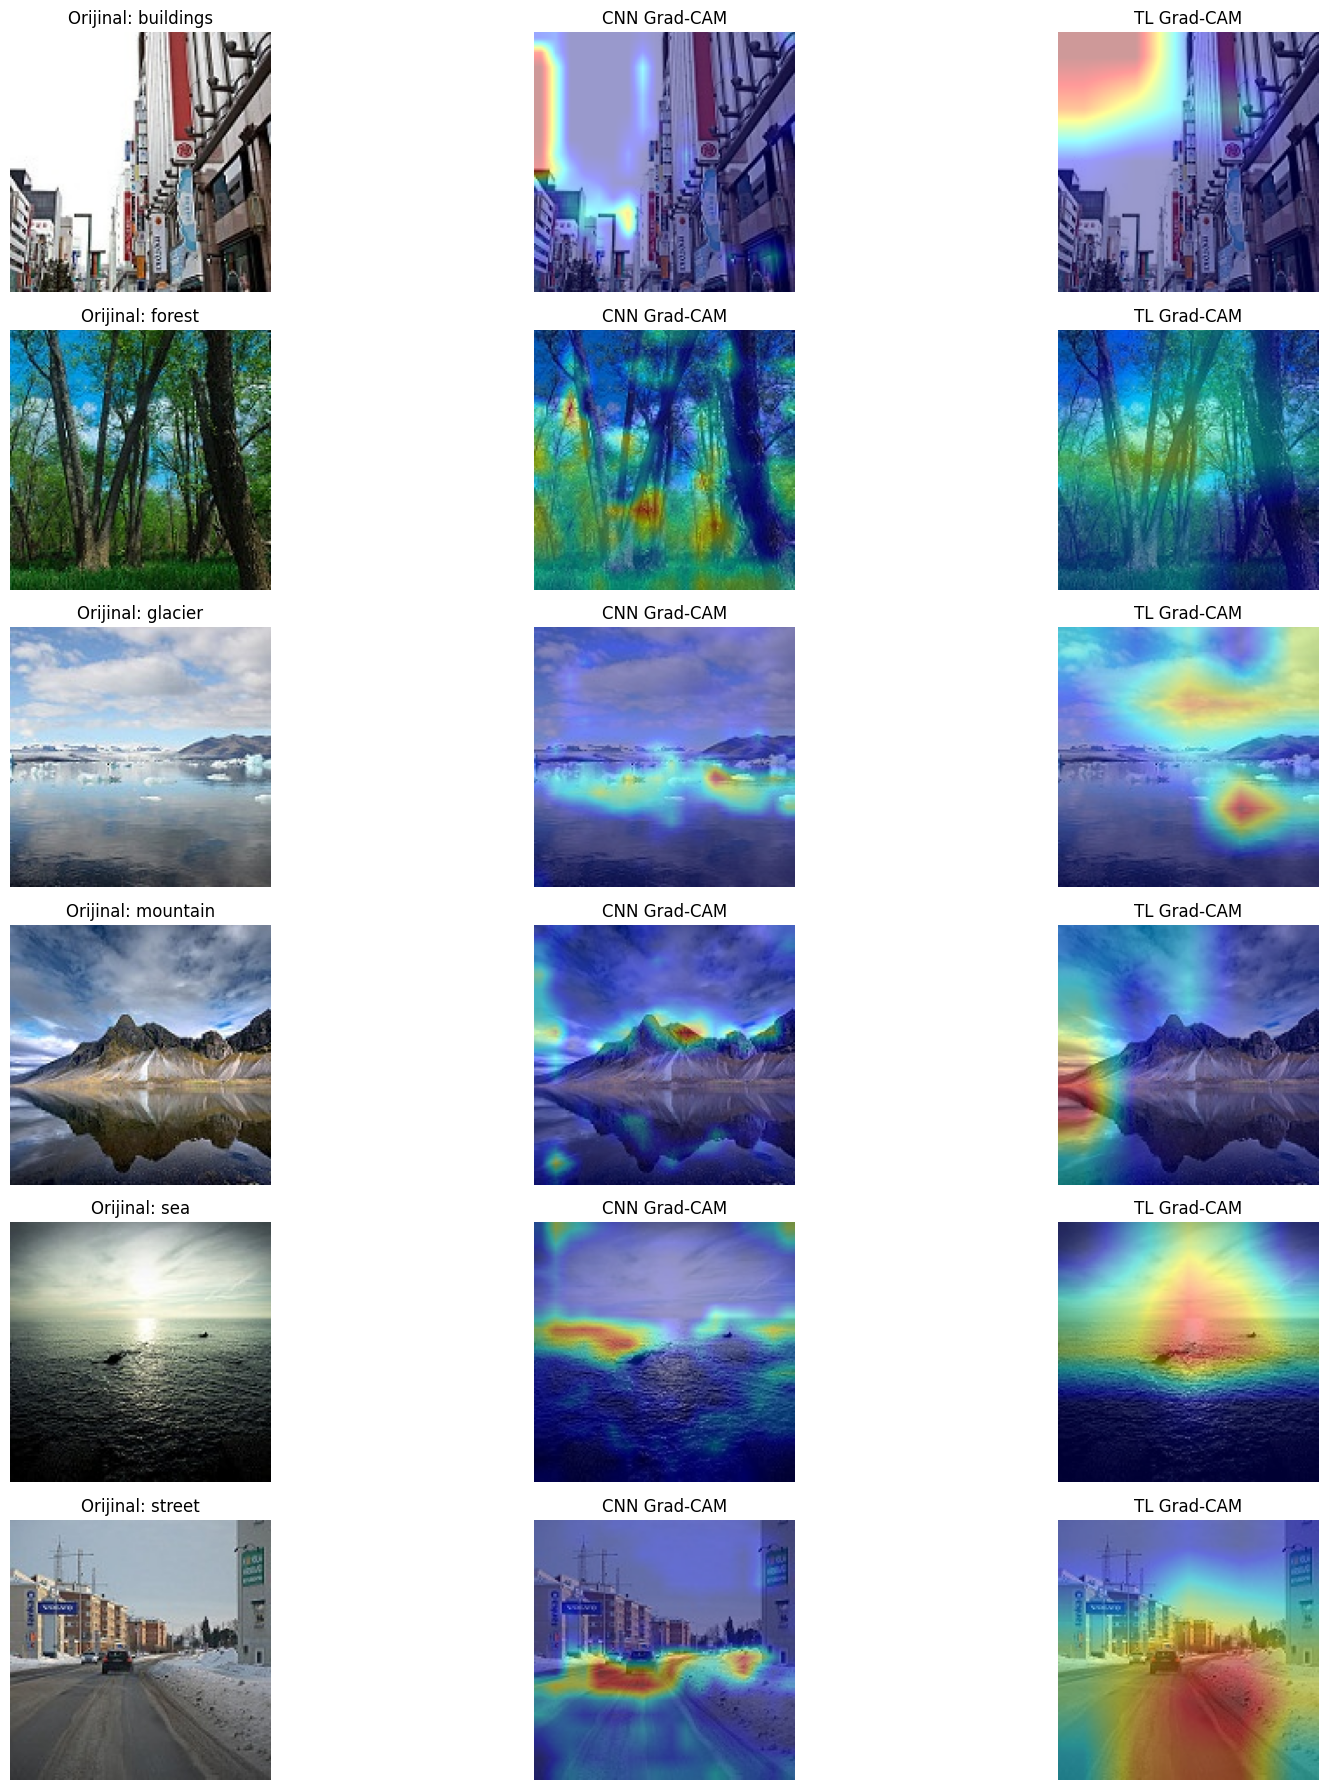

In [78]:
for layer in base_model.layers[::-1]:
    if 'conv' in layer.name.lower():
        last_conv_layer_tl = layer.name
        print(f"Son konvolüsyon katmanı bulundu: {last_conv_layer_tl}")
        break

n_classes = len(classes)

plt.figure(figsize=(18, 3 * n_classes))
for idx, cls in enumerate(classes):
    cls_idx = classes.index(cls)
    cls_paths = [p for p,l in zip(test_paths,test_labels) if l==cls_idx]
    sample_path = random.choice(cls_paths)

    # CNN Grad-CAM
    gradcam_cnn = display_gradcam(sample_path, cnn_model, last_conv_layer_cnn, class_idx=cls_idx)
    # TL Grad-CAM
    gradcam_tl = display_gradcam(sample_path, tl_model, last_conv_layer_tl, class_idx=cls_idx)

    # Orijinal Görsel
    plt.subplot(n_classes, 3, 3*idx+1)
    plt.imshow(tf.keras.utils.load_img(sample_path))
    plt.title(f"Orijinal: {cls}")
    plt.axis("off")

    # CNN Grad-CAM
    plt.subplot(n_classes, 3, 3*idx+2)
    plt.imshow(gradcam_cnn)
    plt.title("CNN Grad-CAM")
    plt.axis("off")

    # TL Grad-CAM
    plt.subplot(n_classes, 3, 3*idx+3)
    plt.imshow(gradcam_tl)
    plt.title("TL Grad-CAM")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Grad-CAM Karşılaştırması

Bu hücrede amaç, **CNN ve Transfer Learning modellerinin Grad-CAM görselleştirmelerini yan yana karşılaştırmak** ve her sınıf için modelin dikkat ettiği bölgeleri incelemektir.

---

## Adımlar

### 1. Parametreler
- `last_conv_layer_tl` → MobileNetV2 modelinin son konvolüsyon katmanı otomatik seçilir.
- `n_classes = len(classes)` → Toplam sınıf sayısı.

### 2. Figure Oluşturma
- `plt.figure(figsize=(18, 3 * n_classes))` → Her sınıf için üç sütun (Orijinal, CNN Grad-CAM, TL Grad-CAM) ve n_classes kadar satır olacak şekilde boyutlandırılır.

### 3. Döngü ile Sınıf Bazlı Görselleştirme
- Her sınıf için:
  1. Test setinden rastgele bir örnek seçilir (`sample_path`).
  2. **CNN Grad-CAM**: `display_gradcam(sample_path, cnn_model, last_conv_layer_cnn, class_idx=cls_idx)`  
  3. **TL Grad-CAM**: `display_gradcam(sample_path, tl_model, last_conv_layer_tl, class_idx=cls_idx)`  
  4. **Orijinal görsel** subplot’a eklenir.
  5. **CNN Grad-CAM görseli** subplot’a eklenir.
  6. **Transfer Learning Grad-CAM görseli** subplot’a eklenir.
- Başlıklar eklenir (`Orijinal`, `CNN Grad-CAM`, `TL Grad-CAM`) ve eksenler kapatılır.

### 4. Layout ve Gösterim
- `plt.tight_layout()` → Alt grafikler arasında boşluk düzenlenir.
- `plt.show()` → Tüm görseller ekranda gösterilir.

---

- Grad-CAM görselleştirmeleri sayesinde:
  - Modelin hangi bölgeleri dikkate aldığı anlaşılır.
  - CNN ve Transfer Learning modellerinin farklılıkları gözlemlenebilir.

In [79]:
def build_hyper_cnn(hp):
    inputs = layers.Input(shape=(150,150,3))

    x = inputs
    for i in range(hp.Int("conv_blocks", 2, 4, default=3)): 
        filters = hp.Choice(f"filters_{i}", [32, 64, 128])
        kernel_size = hp.Choice(f"kernel_size_{i}", [3, 5])
        x = layers.Conv2D(filters, (kernel_size,kernel_size), activation="relu")(x)
        x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)

    dense_units = hp.Choice("dense_units", [64, 128, 256])
    x = layers.Dense(dense_units, activation="relu")(x)

    dropout_rate = hp.Float("dropout_rate", 0.3, 0.6, step=0.1, default=0.5)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = models.Model(inputs, outputs)

    learning_rate = hp.Choice("lr", [1e-2, 1e-3, 1e-4])
    optimizer = hp.Choice("optimizer", ["adam", "sgd", "rmsprop"])
    if optimizer == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


# Hücre 13: HyperModel Tanımı

Bu hücrede amaç, **Keras Tuner ile hiperparametre optimizasyonu yapabilmek için bir HyperModel tanımlamaktır**. Modelin yapısı ve optimizer seçimleri, tuner tarafından denenecek şekilde parametrik hale getirilmiştir.

---

## Fonksiyon: `build_hyper_cnn(hp)`

### 1. Girdi Katmanı
- `inputs = layers.Input(shape=(150,150,3))`  
- Model 150x150 boyutunda 3 kanallı (RGB) görüntüleri alır.

### 2. Convolutional Bloklar
- `hp.Int("conv_blocks", 2, 4, default=3)` → 2 ila 4 arasında konvolüsyon bloğu denenebilir.
- Her blokta:
  - `filters = hp.Choice(f"filters_{i}", [32, 64, 128])` → Filtre sayısı seçilir.
  - `kernel_size = hp.Choice(f"kernel_size_{i}", [3,5])` → Kernel boyutu seçilir.
  - `Conv2D` → Aktivasyon: "relu"
  - `MaxPooling2D` → Pooling boyutu: (2,2)

### 3. Flatten Katmanı
- Konvolüsyon ve pooling sonrası feature map’ler tek boyutlu vektöre çevrilir: `layers.Flatten()`

### 4. Dense Katmanı
- `dense_units = hp.Choice("dense_units", [64,128,256])` → Dense katman boyutu seçilir.
- Aktivasyon: "relu"

### 5. Dropout Katmanı
- `dropout_rate = hp.Float("dropout_rate", 0.3, 0.6, step=0.1, default=0.5)`  
- Dropout modeli overfitting’e karşı düzenler.

### 6. Çıkış Katmanı
- `Dense(NUM_CLASSES, activation="softmax")` → Sınıflandırma için softmax aktivasyonu.

### 7. Optimizer Seçimi
- `hp.Choice("lr", [1e-2,1e-3,1e-4])` → Öğrenme oranı tuner tarafından seçilir.
- `hp.Choice("optimizer", ["adam","sgd","rmsprop"])` → Optimizer seçimi:
  - Adam: `tf.keras.optimizers.Adam`
  - SGD: `tf.keras.optimizers.SGD(momentum=0.9)`
  - RMSprop: `tf.keras.optimizers.RMSprop`

### 8. Model Compile
- Loss: `"categorical_crossentropy"`
- Metrics: `["accuracy"]`



In [81]:
tuner = kt.RandomSearch(
    build_hyper_cnn,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="tuner_dir",
    project_name="cnn_tuning"
)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("En iyi hiperparametreler:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")


Reloading Tuner from tuner_dir/cnn_tuning/tuner0.json
En iyi hiperparametreler:
conv_blocks: 3
filters_0: 32
kernel_size_0: 3
filters_1: 64
kernel_size_1: 5
filters_2: 64
kernel_size_2: 5
dense_units: 256
dropout_rate: 0.3
lr: 0.001
optimizer: rmsprop


# Keras Tuner ile Hiperparametre Araması

Bu hücrede amaç, **Keras Tuner kullanarak CNN modelinin en iyi hiperparametre kombinasyonunu bulmak** ve model performansını artırmaktır.

---

## Adımlar

### 1. Tuner Tanımı
```python
tuner = kt.RandomSearch(
    build_hyper_cnn,
    objective="val_accuracy",
    max_trials=5,               
    executions_per_trial=1,     
    directory="tuner_dir",
    project_name="cnn_tuning"
)
```
- `build_hyper_cnn:` Daha önce tanımlanan HyperModel fonksiyonu.
- `objective="val_accuracy"` → Doğrulama doğruluğunu maksimize etmeye çalışır.
- `max_trials=5` → Toplam 5 farklı hiperparametre kombinasyonu denenir.
- `executions_per_trial=1` → Her deneme tek sefer çalıştırılır.
- `directory ve project_name` → Tuner sonuçlarının kaydedileceği dizin ve proje adı.

### 2. Hiperparametre Araması
```python
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)
```
- train_ds ve val_ds ile modeller eğitilir.
- epochs=5 → Her deneme 5 epoch boyunca çalıştırılır.
- verbose=1 → Eğitim sırasında ilerleme gösterilir.

### 3. En İyi Hiperparametrelerin Alınması
```python
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
for param, value in best_hp.values.items():
    print(f"{param}: {value}")
```
- `get_best_hyperparameters(num_trials=1)` → En iyi denemeyi alır.
- Hiperparametreler ekrana yazdırılır.

---

- Çıktıda görülen en iyi hiperparametreler, daha sonraki model eğitimi için kullanılabilir.
- Bu yöntem, elle deneme-yanılma yerine sistematik hiperparametre optimizasyonu sağlar.